# SHAP Interpretation for ECGTransForm
Use SHAP (SHapley Additive Explanations) to interpret the ECGTransForm model on ECG time series.

In [1]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

/Users/canhu/miniforge3/envs/wfdb-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the trained model and dataset

In [2]:
# Adjust paths to match your environment
from models import ecgTransForm
from configs.data_configs import mit
from configs.hparams import supervised

mit_cfg = mit()
hparams = supervised().train_params

checkpoint_path = 'experiments_logs/Exp1/run1_23_12/checkpoint_best.pt'  # update 
checkpoint = torch.load(checkpoint_path, map_location='cpu')

model = ecgTransForm(configs=mit_cfg, hparams=hparams)
model.load_state_dict(checkpoint['model'])
model.eval();

/Users/canhu/miniforge3/envs/wfdb-env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [19]:
train = torch.load('data/mit/train.pt', weights_only=False)
test = torch.load('data/mit/test.pt', weights_only=False)

# Try with small samples first 
X_background = train['samples'][:200] # [:100]
X_test = test['samples'][:30]   # [:10] 
y_test = test['labels'][:30]    # [:10] 

# Generate a list of indices for each class
class_indices = {i: np.where(train['labels'] == i)[0] for i in range(0, 5)}

In [ ]:
print(y_test)# Find index of element with value = 2
print(np.where(y_test == 2)[0])

[4 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 2 0 2 0 2 1 0 0]
[10 12 22 24 26]


## Define model prediction wrapper for SHAP

In [4]:
def predict_fn(x_numpy):
    x_tensor = torch.from_numpy(x_numpy).float().unsqueeze(1)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = F.softmax(logits, dim=1).numpy()
    return probs

## Compute SHAP values using KernelExplainer

X_test: no. samples to interpret -- linear increase of resources 

X_background: baseline distribution for estimating feature importance -- slower per sample

n_samples: no. of perturbations per test sample

- 1 min: 100, 10, 10
- 3 min: 200, 20, 20
- 4.5 min: 200, 30, 30

In [21]:
explainer = shap.KernelExplainer(predict_fn, X_background)
shap_values = explainer.shap_values(X_test, nsamples=10)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/30 [00:00<?, ?it/s]/Users/canhu/miniforge3/envs/wfdb-env/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.765e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/canhu/miniforge3/envs/wfdb-env/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.382e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/canhu/miniforge3/envs

In [6]:
print(len(shap_values))
print(len(shap_values[0]))
print(len(shap_values[9][0]))
print(shap_values[9][0].shape)
print(shap_values[9][185][4])
# shap_values[sample][feature][class]

10
186
5
(5,)
0.0


## Plot SHAP values over time

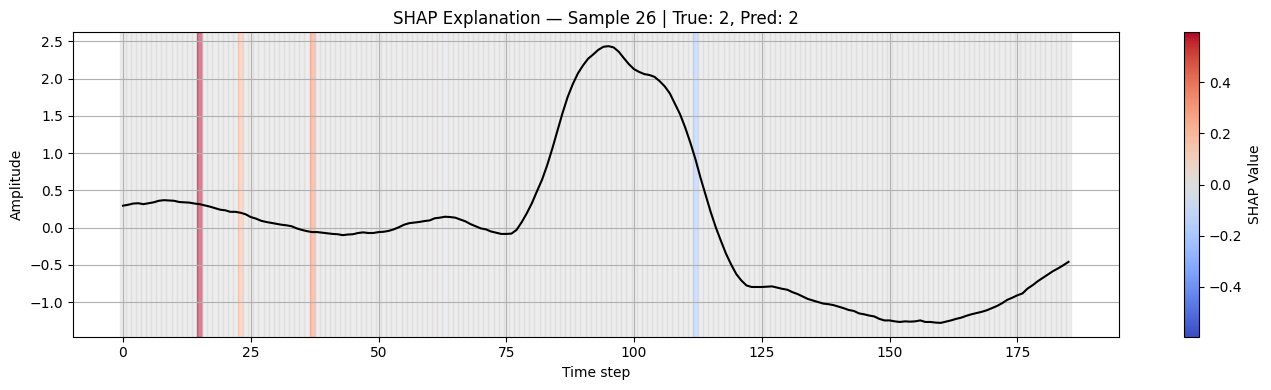

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl

sample_idx = 26         # index of the sample to visualize
x = X_test[sample_idx]
true_label = y_test[sample_idx]
pred_label = np.argmax(predict_fn(X_test)[sample_idx]) # predicted class determined via highest probability

# Get the SHAP values for the predicted class
shap_line = np.array([shap_values[sample_idx][i][pred_label] for i in range(len(x))]) # shape: (186,)

# Plot
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(x, label='ECG Signal', color='black') # ECG signal

# SHAP background coloring
cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(vmin=-np.max(np.abs(shap_line)), vmax=np.max(np.abs(shap_line)))

for i in range(len(x)):
    ax.axvspan(i - 0.5, i + 0.5, color=cmap(norm(shap_line[i])), alpha=0.5)

# Labels and formatting
ax.set_title(f"SHAP Explanation — Sample {sample_idx} | True: {true_label}, Pred: {pred_label}")
ax.set_xlabel("Time step")
ax.set_ylabel("Amplitude")
ax.grid(True)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required to create an empty mappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("SHAP Value")

plt.tight_layout()
plt.show()